In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")

/tmp/ipykernel_42468/2370551333.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")


# Choice of unit = gram per International Dollar

In [5]:
df = df[df["Unit"] == "g/Int$"]

# Mean and Variance of g/Int$

In [6]:
continents_to_filter = ['Africa', 'Asia', 'Europe', 'Northern America', 'Central America', 'South America', 'Oceania']
filtered_df = df[df['Area'].isin(continents_to_filter)]

In [7]:
grouped_stats = filtered_df.groupby('Area')['Value'].agg(['mean', 'std'])
grouped_stats

,mean,std
Area,,
Africa,0.428438,0.063860
Asia,0.594688,0.065795
Central America,1.210000,0.181659
Europe,0.918750,0.049693
Northern America,1.332812,0.118872
Oceania,0.830000,0.186496
South America,1.707812,0.613976


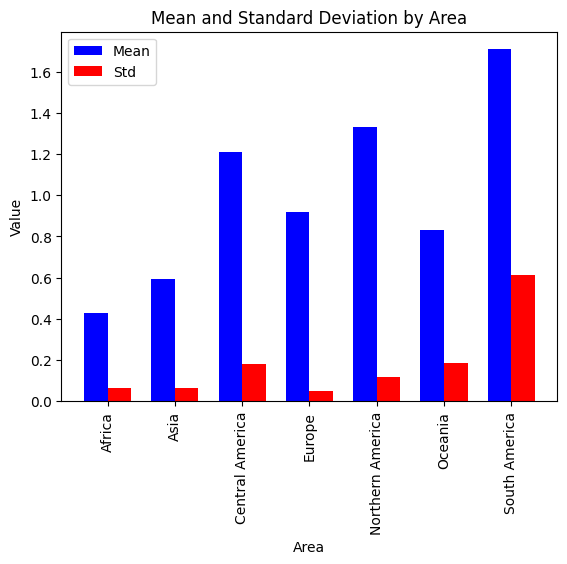

In [8]:
import matplotlib.pyplot as plt
df = grouped_stats

# Plotting grouped bar chart
fig, ax = plt.subplots()

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = range(len(df))

# Plotting bars for mean
bars1 = ax.bar(x, df['mean'], width=bar_width, label='Mean', color='b')

# Plotting bars for standard deviation
bars2 = ax.bar([p + bar_width for p in x], df['std'], width=bar_width, label='Std', color='r')

# Labeling the x-axis ticks with area names
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(df.index, rotation=90)

# Adding labels, title, and legend
ax.set_xlabel('Area')
ax.set_ylabel('Value')
ax.set_title('Mean and Standard Deviation by Area')
ax.legend()

# Show the plot
plt.show()

# Trend analysis of 7 regions (1990-2021)

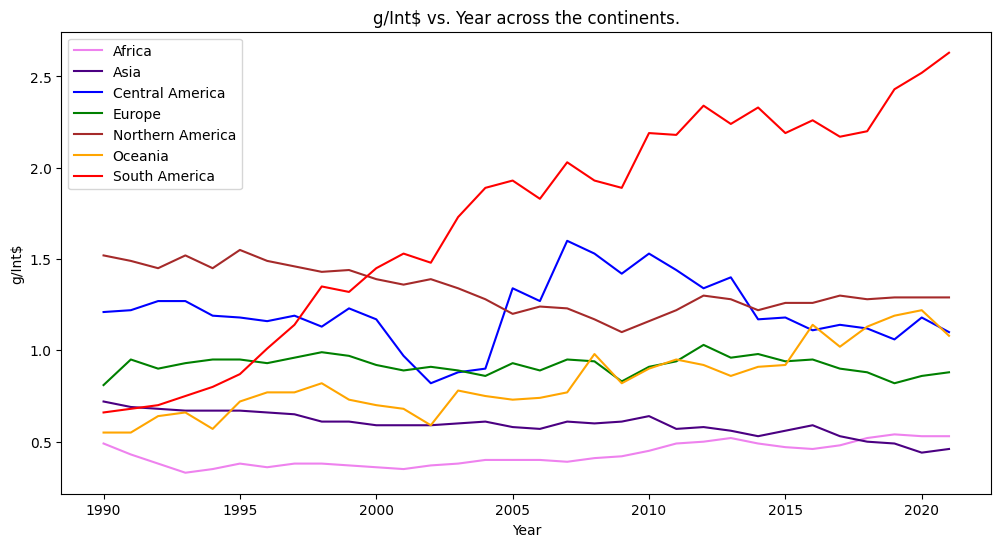

In [9]:
import matplotlib.pyplot as plt
groupedseries = filtered_df.groupby('Area')
listofdfs = [group for _, group in groupedseries]
colors = ['violet','indigo','blue','green','brown','orange','red']
plt.figure(figsize=[12,6])
for i in range(len(listofdfs)):
    temp = listofdfs[i]
    label = temp['Area'].unique()[0]
    plt.plot(
        temp['Year'],
        temp['Value'],
        marker = None,
        linestyle = '-',
        color = colors[i],
        label =label
    )
plt.xlabel('Year')
plt.ylabel('g/Int$')
plt.title('g/Int$ vs. Year across the continents.')
plt.legend()
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

# Step 1: check for stationarity of time-series

## Method 1: time series plot

In [11]:
traindfs = []
testdfs = []
for i in range(len(listofdfs)):
    traindfs.append(listofdfs[i].head(len(listofdfs[i])-1))
    testdfs.append(listofdfs[i].tail(1))

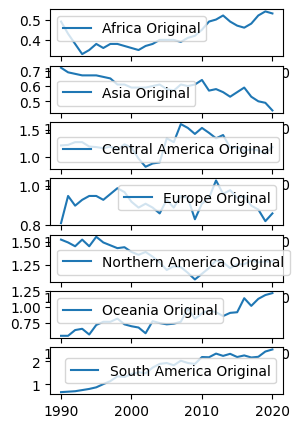

In [12]:
fig, axs = plt.subplots(len(listofdfs),1, figsize=(3,5))
for i in range(len(listofdfs)):
    temp = traindfs[i]
    label = temp['Area'].unique()[0]
    axs[i].plot(temp['Year'], temp['Value'], label = label +" "+ "Original")
    axs[i].legend()

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Method 3: ADF test

In [14]:
# The null hypothesis in the ADF test is: the time series is non-stationary
# If p < 0.5 we reject the null == the time series is non-stationary
# Let us see if we reject the null for all the seven time-series

In [15]:
# resource: https://mpra.ub.uni-muenchen.de/69992/10/MPRA_paper_69992.pdf
"""For example, the level of significance should
be set as a decreasing function of sample size (Leamer, 1978; Degroot and Schervish, 2012;
Section 9.9), and with a full consideration of the implications of Type I and Type II errors (see,
for example, Skipper et al., 19671
)."""

"""α = 0.10 (10%): A more lenient threshold, sometimes used in exploratory studies or when the sample size is small, to increase the power of the test and decrease the chance of a Type II error (failing to detect stationarity when it exists)."""

'α = 0.10 (10%): A more lenient threshold, sometimes used in exploratory studies or when the sample size is small, to increase the power of the test and decrease the chance of a Type II error (failing to detect stationarity when it exists).'

In [16]:
from statsmodels.tsa.stattools import adfuller
for i in range(len(traindfs)): 
    temp = traindfs[i]
    label = temp['Area'].unique()[0]
    y = temp["Value"]
    adf_test = adfuller(y)
    print("p-value = "+str(adf_test[1]) + " for "+label)

p-value = 0.22387709578732895 for Africa
p-value = 0.8808034257898254 for Asia
p-value = 0.0451662891591232 for Central America
p-value = 0.0016448342414842848 for Europe
p-value = 0.44787654126717014 for Northern America
p-value = 0.9977472938234591 for Oceania
p-value = 0.06341469876717186 for South America


In [17]:
def find_d(timeseries, p_value):
    p = adfuller(timeseries)[1]
    if p < p_value:
        return 0
    return 1 + find_d(timeseries.diff().dropna(), p_value)

In [18]:
num_diffs = []
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    number_of_differencing = find_d(traindfs[i]["Value"], 0.1)
    print("Run differencing "+str(number_of_differencing)+" times for "+area)
    num_diffs.append(number_of_differencing)

Run differencing 2 times for Africa
Run differencing 2 times for Asia
Run differencing 0 times for Central America
Run differencing 0 times for Europe
Run differencing 1 times for Northern America
Run differencing 1 times for Oceania
Run differencing 0 times for South America


In [19]:
d = [2, 2, 0, 0, 1, 1, 0 ]

# Determine the p and q values for the arima model

In [20]:
# we will look at the d list and do the diff accordingly and pass the time
# series into csv files and next run the r script
# finally we will look at the acf and pacf plot to decide on the p and q values

In [21]:
def plottimeseries(data, area):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Plot ACF on the first subplot
    plot_acf(data, lags=14, ax=axes[0])  # You can change 'lags' to the number of lags you want
    axes[0].set_title('Autocorrelation Function (ACF) for ' + area)

    # Plot PACF on the second subplot
    plot_pacf(data, lags=14, ax=axes[1], method='ywm')  # 'ywm' is one of the methods; you can try 'ols' or 'ld' too
    axes[1].set_title('Partial Autocorrelation Function (PACF) for ' + area)

    # Show the plot
    plt.tight_layout()
    plt.show()

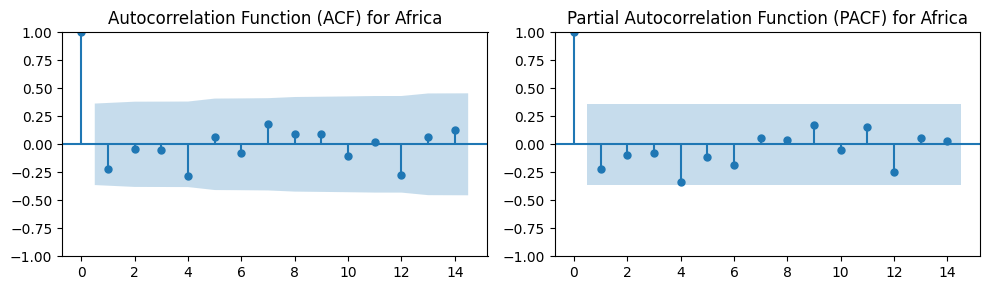

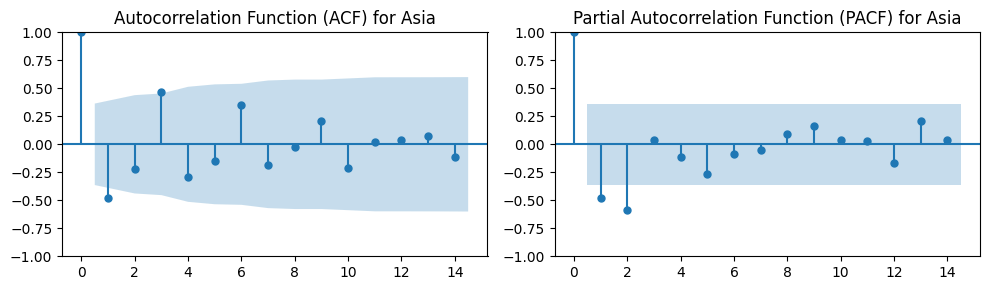

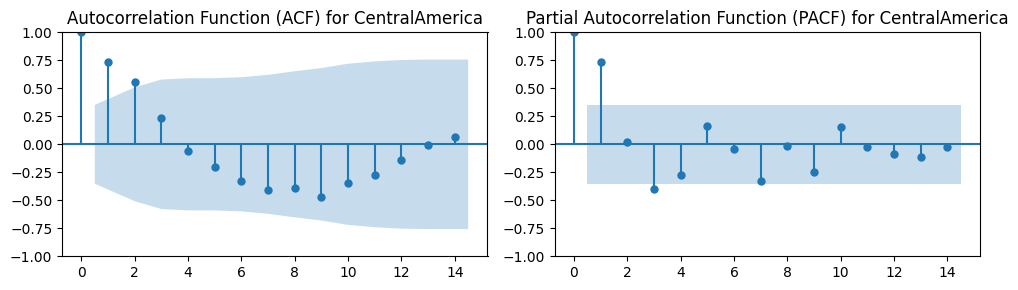

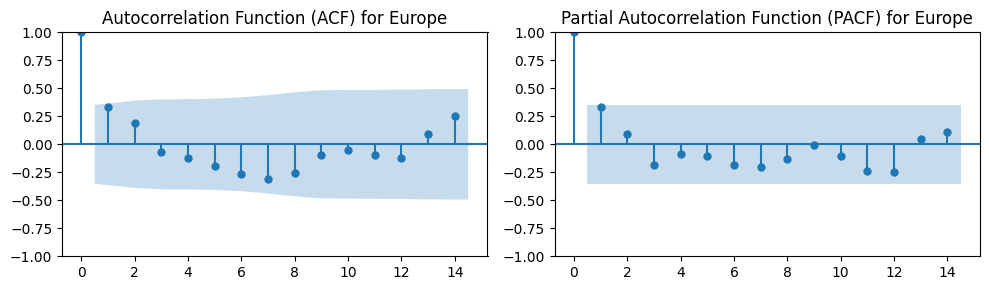

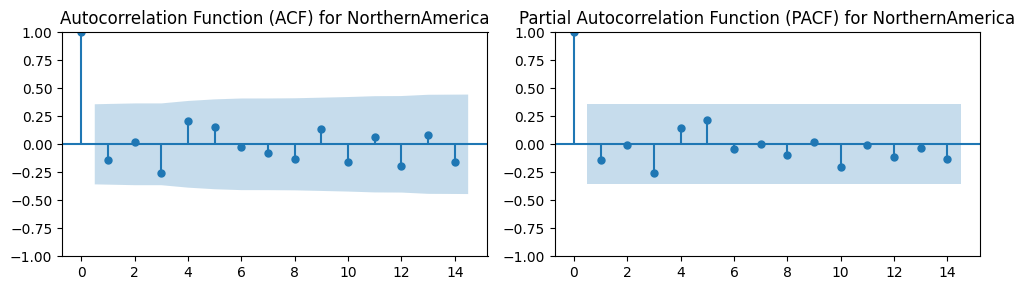

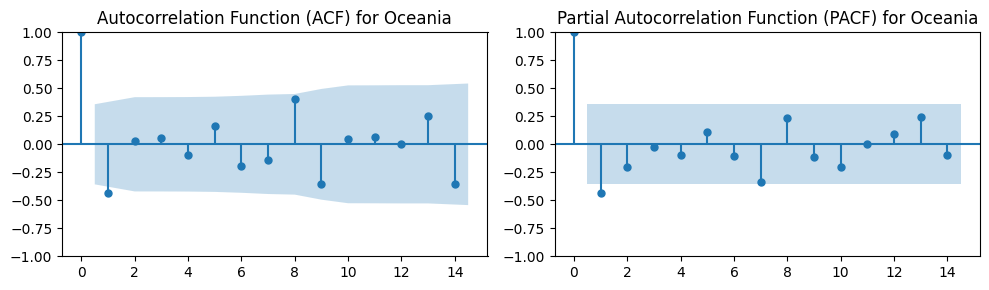

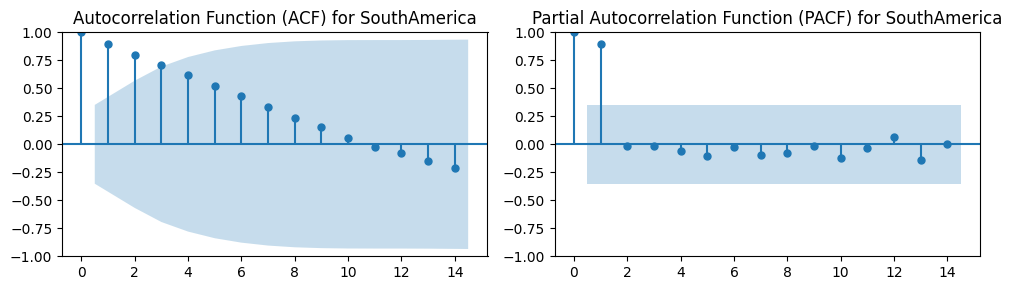

In [22]:
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    area = area.replace(" ", "")
    timeseries = traindfs[i]["Value"]
    test = testdfs[i]["Value"]
    originaldf = {"y":test}
    temporiginal = pd.DataFrame(originaldf)
    temporiginal.to_csv("./Input/"+area+"_original.csv")
    delx = d[i]
    while delx > 0:
        timeseries =  timeseries.diff().dropna()
        delx -= 1
    plottimeseries(timeseries, area)
    data = {"y":timeseries}
    temp = pd.DataFrame(data)
    temp.to_csv("./Input/"+area+".csv")

In [23]:
# we choose the d parameter with the help of the adf test
# the sample size is 31, therefore the level of significance is taken to be 0.1
# based on that the pdq params are as follows
# africa(0,2,0), asia(2,2,3), central america(3,0,2), europe(1,0,1), northern america(0,1,0), oceania(7,1,8), south america (1,0,3)

In [22]:
ps = [0,2,3,1,0,7,1] 
ds = [2,2,0,0,1,1,0]
qs = [0,3,2,1,0,8,3]

In [23]:
from statsmodels.tsa.arima.model import ARIMA
forecasts = []
for i in range(len(ps)):
    continent = traindfs[i]["Value"]
    model = ARIMA(continent, order = (ps[i],ds[i],qs[i]))
    model_fit = model.fit()
    continent_test = testdfs[i]["Value"]
    forecast_test = model_fit.forecast(len(continent_test))
    #print(forecast_test)
    forecasts.append(forecast_test)

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is av

In [24]:
################# up until this #########################

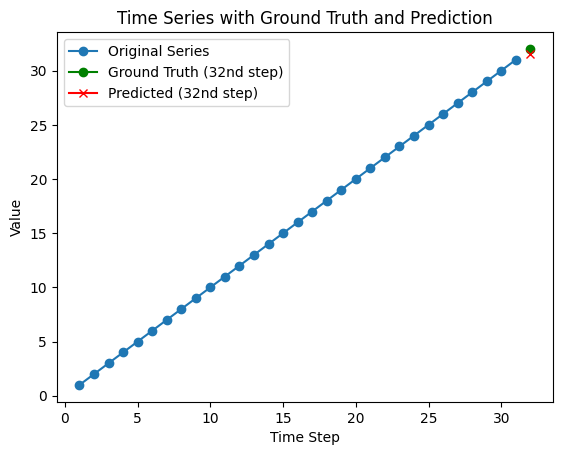

In [25]:
import matplotlib.pyplot as plt

# Suppose this is your original time series (with 31 points)
original_series = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
                   16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
                   
# Ground truth for the 32nd time step (the one you kept for testing)
ground_truth = 32

# Predicted value for the 32nd time step
predicted_value = 31.5  # Example prediction

# Create a list for plotting that includes the original series and the ground truth
time_steps = list(range(1, 33))  # 32 time steps including the test step
extended_series = original_series + [ground_truth]

# Plot original time series (first 31 points)
plt.plot(time_steps[:31], original_series, label='Original Series', marker='o')

# Plot the ground truth for the 32nd time step
plt.plot(32, ground_truth, label='Ground Truth (32nd step)', color='green', marker='o')

# Plot the predicted value for the 32nd time step
plt.plot(32, predicted_value, label='Predicted (32nd step)', color='red', marker='x')

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series with Ground Truth and Prediction')
plt.legend()

# Show the plot
plt.show()


In [26]:
ground_truths = []
for i in range(len(testdfs)):
    ground_truths.append(testdfs[i]["Value"])

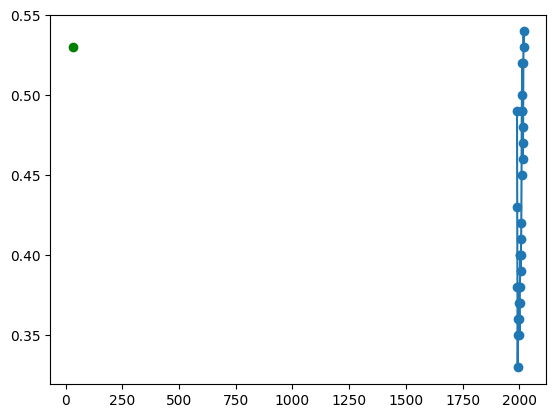

In [33]:

groundtruth = ground_truths[0]
continent = traindfs[0]["Value"].tolist()
years = traindfs[0]["Year"].tolist()

extendedseries = continent + [groundtruth]
# Plot original time series (first 31 points)
plt.plot(years[:31], continent, label='Original Series', marker='o')

# Plot the ground truth for the 32nd time step
plt.plot(32, groundtruth, label='Ground Truth (32nd step)', color='green', marker='o')

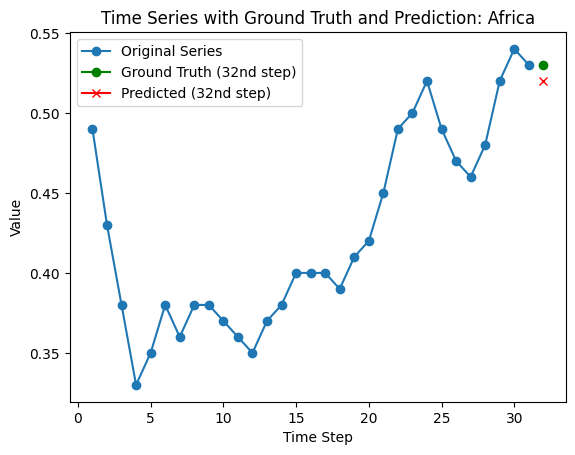

In [46]:
import matplotlib.pyplot as plt

# Suppose this is your original time series (with 31 points)
original_series = traindfs[0]["Value"].tolist()
                   
# Ground truth for the 32nd time step (the one you kept for testing)
ground_truth = ground_truths[0]

# Predicted value for the 32nd time step
predicted_value = forecasts[0]  # Example prediction

# Create a list for plotting that includes the original series and the ground truth
time_steps = list(range(1, 33))  # 32 time steps including the test step
extended_series = original_series + [ground_truth]

# Plot original time series (first 31 points)
plt.plot(time_steps[:31], original_series, label='Original Series', marker='o')

# Plot the ground truth for the 32nd time step
plt.plot(32, ground_truth, label='Ground Truth (32nd step)', color='green', marker='o')

# Plot the predicted value for the 32nd time step
plt.plot(32, predicted_value, label='Predicted (32nd step)', color='red', marker='x')

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series with Ground Truth and Prediction: '+traindfs[0]["Area"].unique()[0])
plt.legend()

# Show the plot
plt.show()


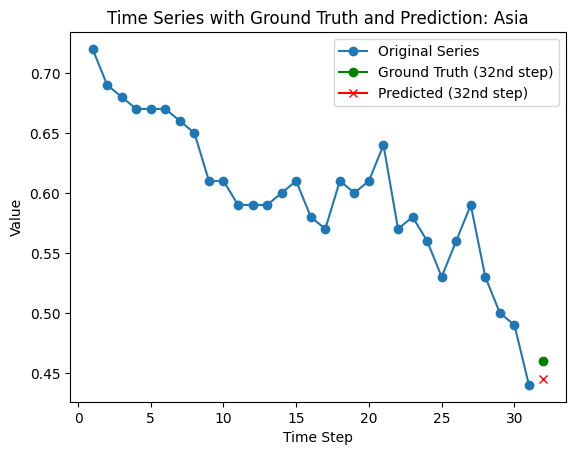

In [47]:
import matplotlib.pyplot as plt

# Suppose this is your original time series (with 31 points)
original_series = traindfs[1]["Value"].tolist()
                   
# Ground truth for the 32nd time step (the one you kept for testing)
ground_truth = ground_truths[1]

# Predicted value for the 32nd time step
predicted_value = forecasts[1]  # Example prediction

# Create a list for plotting that includes the original series and the ground truth
time_steps = list(range(1, 33))  # 32 time steps including the test step
extended_series = original_series + [ground_truth]

# Plot original time series (first 31 points)
plt.plot(time_steps[:31], original_series, label='Original Series', marker='o')

# Plot the ground truth for the 32nd time step
plt.plot(32, ground_truth, label='Ground Truth (32nd step)', color='green', marker='o')

# Plot the predicted value for the 32nd time step
plt.plot(32, predicted_value, label='Predicted (32nd step)', color='red', marker='x')

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series with Ground Truth and Prediction: '+traindfs[1]["Area"].unique()[0])
plt.legend()

# Show the plot
plt.show()


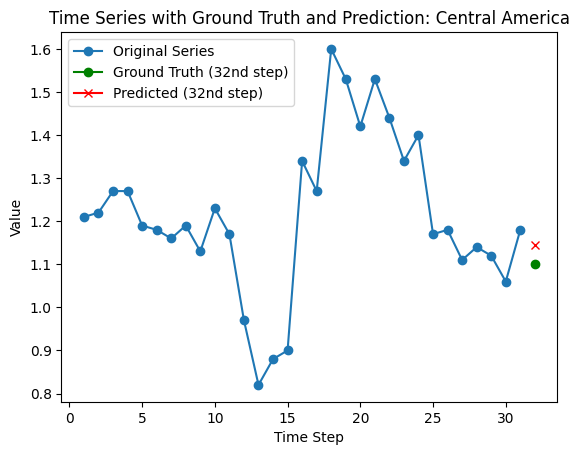

In [48]:
import matplotlib.pyplot as plt

# Suppose this is your original time series (with 31 points)
original_series = traindfs[2]["Value"].tolist()
                   
# Ground truth for the 32nd time step (the one you kept for testing)
ground_truth = ground_truths[2]

# Predicted value for the 32nd time step
predicted_value = forecasts[2]  # Example prediction

# Create a list for plotting that includes the original series and the ground truth
time_steps = list(range(1, 33))  # 32 time steps including the test step
extended_series = original_series + [ground_truth]

# Plot original time series (first 31 points)
plt.plot(time_steps[:31], original_series, label='Original Series', marker='o')

# Plot the ground truth for the 32nd time step
plt.plot(32, ground_truth, label='Ground Truth (32nd step)', color='green', marker='o')

# Plot the predicted value for the 32nd time step
plt.plot(32, predicted_value, label='Predicted (32nd step)', color='red', marker='x')

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series with Ground Truth and Prediction: '+traindfs[2]["Area"].unique()[0])
plt.legend()

# Show the plot
plt.show()


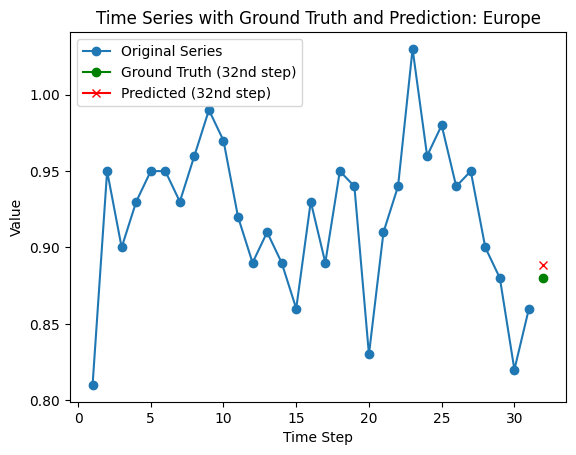

In [49]:
import matplotlib.pyplot as plt

# Suppose this is your original time series (with 31 points)
original_series = traindfs[3]["Value"].tolist()
                   
# Ground truth for the 32nd time step (the one you kept for testing)
ground_truth = ground_truths[3]

# Predicted value for the 32nd time step
predicted_value = forecasts[3]  # Example prediction

# Create a list for plotting that includes the original series and the ground truth
time_steps = list(range(1, 33))  # 32 time steps including the test step
extended_series = original_series + [ground_truth]

# Plot original time series (first 31 points)
plt.plot(time_steps[:31], original_series, label='Original Series', marker='o')

# Plot the ground truth for the 32nd time step
plt.plot(32, ground_truth, label='Ground Truth (32nd step)', color='green', marker='o')

# Plot the predicted value for the 32nd time step
plt.plot(32, predicted_value, label='Predicted (32nd step)', color='red', marker='x')

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series with Ground Truth and Prediction: '+traindfs[3]["Area"].unique()[0])
plt.legend()

# Show the plot
plt.show()


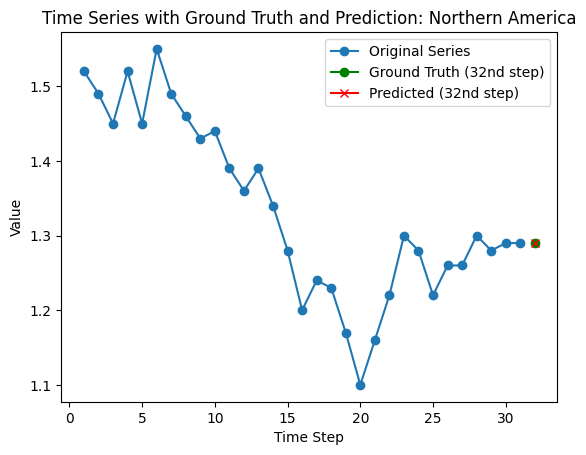

In [50]:
import matplotlib.pyplot as plt

# Suppose this is your original time series (with 31 points)
original_series = traindfs[4]["Value"].tolist()
                   
# Ground truth for the 32nd time step (the one you kept for testing)
ground_truth = ground_truths[4]

# Predicted value for the 32nd time step
predicted_value = forecasts[4]  # Example prediction

# Create a list for plotting that includes the original series and the ground truth
time_steps = list(range(1, 33))  # 32 time steps including the test step
extended_series = original_series + [ground_truth]

# Plot original time series (first 31 points)
plt.plot(time_steps[:31], original_series, label='Original Series', marker='o')

# Plot the ground truth for the 32nd time step
plt.plot(32, ground_truth, label='Ground Truth (32nd step)', color='green', marker='o')

# Plot the predicted value for the 32nd time step
plt.plot(32, predicted_value, label='Predicted (32nd step)', color='red', marker='x')

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series with Ground Truth and Prediction: '+traindfs[4]["Area"].unique()[0])
plt.legend()

# Show the plot
plt.show()


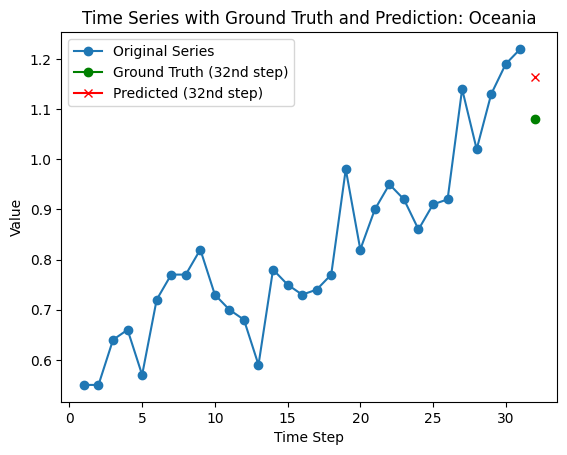

In [51]:
import matplotlib.pyplot as plt

# Suppose this is your original time series (with 31 points)
original_series = traindfs[5]["Value"].tolist()
                   
# Ground truth for the 32nd time step (the one you kept for testing)
ground_truth = ground_truths[5]

# Predicted value for the 32nd time step
predicted_value = forecasts[5]  # Example prediction

# Create a list for plotting that includes the original series and the ground truth
time_steps = list(range(1, 33))  # 32 time steps including the test step
extended_series = original_series + [ground_truth]

# Plot original time series (first 31 points)
plt.plot(time_steps[:31], original_series, label='Original Series', marker='o')

# Plot the ground truth for the 32nd time step
plt.plot(32, ground_truth, label='Ground Truth (32nd step)', color='green', marker='o')

# Plot the predicted value for the 32nd time step
plt.plot(32, predicted_value, label='Predicted (32nd step)', color='red', marker='x')

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series with Ground Truth and Prediction: '+traindfs[5]["Area"].unique()[0])
plt.legend()

# Show the plot
plt.show()


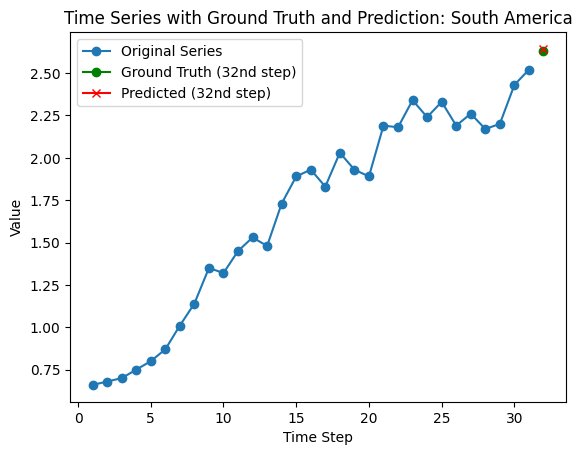

In [52]:
import matplotlib.pyplot as plt

# Suppose this is your original time series (with 31 points)
original_series = traindfs[6]["Value"].tolist()
                   
# Ground truth for the 32nd time step (the one you kept for testing)
ground_truth = ground_truths[6]

# Predicted value for the 32nd time step
predicted_value = forecasts[6]  # Example prediction

# Create a list for plotting that includes the original series and the ground truth
time_steps = list(range(1, 33))  # 32 time steps including the test step
extended_series = original_series + [ground_truth]

# Plot original time series (first 31 points)
plt.plot(time_steps[:31], original_series, label='Original Series', marker='o')

# Plot the ground truth for the 32nd time step
plt.plot(32, ground_truth, label='Ground Truth (32nd step)', color='green', marker='o')

# Plot the predicted value for the 32nd time step
plt.plot(32, predicted_value, label='Predicted (32nd step)', color='red', marker='x')

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series with Ground Truth and Prediction: '+traindfs[6]["Area"].unique()[0])
plt.legend()

# Show the plot
plt.show()


In [321]:
model = ARIMA(sa, order = (1,0,3))

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [322]:
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   31
Model:                 ARIMA(1, 0, 3)   Log Likelihood                  21.110
Date:                Wed, 02 Oct 2024   AIC                            -30.219
Time:                        11:49:30   BIC                            -21.616
Sample:                             0   HQIC                           -27.415
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7549      0.701      2.504      0.012       0.381       3.129
ar.L1          0.9655      0.092     10.466      0.000       0.785       1.146
ma.L1         -0.0212      0.609     -0.035      0.9

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


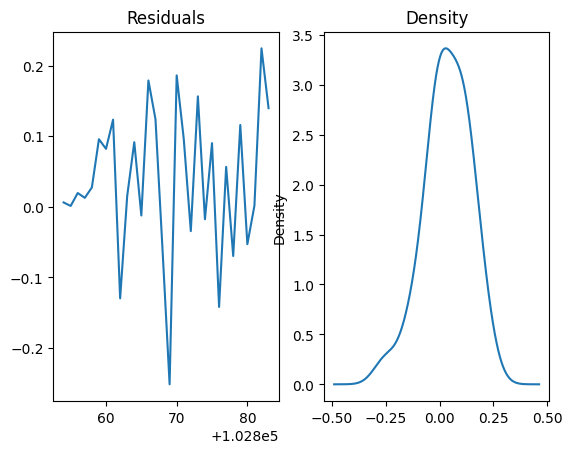

In [323]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Density", kind = "kde", ax = ax[1])
plt.show()

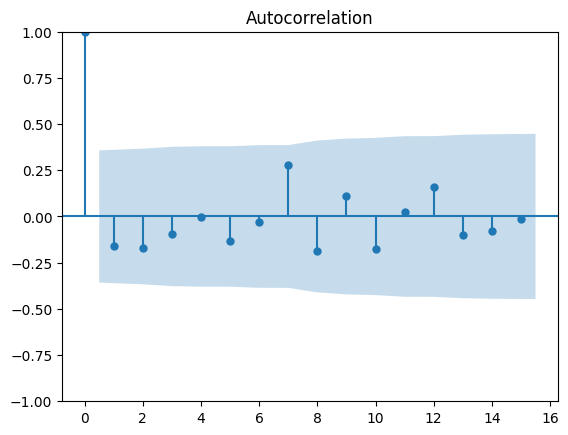

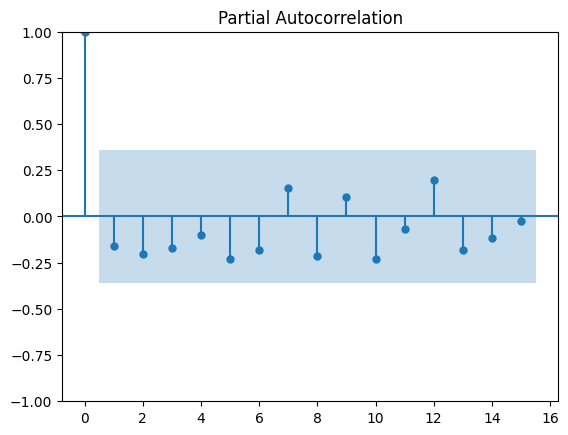

In [324]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


In [326]:
_test = testdfs[6]["Value"]

In [327]:
_test

102884    2.63
Name: Value, dtype: float64

In [328]:
forecast_test = model_fit.forecast(len(_test))

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [329]:
forecast_test

31    2.642306
dtype: float64

In [252]:
import pmdarima as pm

In [253]:
auto_arima = pm.auto_arima(oceania, stepwise=False, seasonal=False)

In [254]:
auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [255]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  47.437
Date:                Sun, 29 Sep 2024   AIC                            -90.874
Time:                        10:52:11   BIC                            -88.072
Sample:                             0   HQIC                           -89.978
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0077      0.010     -0.755      0.450      -0.028       0.012
sigma2         0.0025      0.001      2.561      0.010       0.001       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.41   Prob(JB):                         0.35
Heteroskedasticity (H):               0.70   Skew:                             0.47
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [256]:
forecast_test_auto = auto_arima.predict(n_periods=len(_test))

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [257]:
forecast_test_auto

31    1.282333
dtype: float64

In [212]:
auto_arima.params

<bound method ARIMA.params of ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>

In [73]:
traindfs[1]

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
103301,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1990,1990,g/Int$,0.72,E,NaN
103302,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1991,1991,g/Int$,0.69,E,NaN
103303,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1992,1992,g/Int$,0.68,E,NaN
103304,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1993,1993,g/Int$,0.67,E,NaN
103305,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1994,1994,g/Int$,0.67,E,NaN
103306,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1995,1995,g/Int$,0.67,E,NaN
103307,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1996,1996,g/Int$,0.66,E,NaN
103308,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1997,1997,g/Int$,0.65,E,NaN
103309,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1998,1998,g/Int$,0.61,E,NaN
103310,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1999,1999,g/Int$,0.61,E,NaN


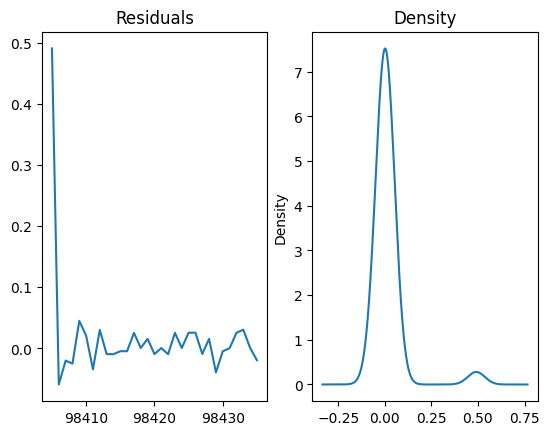

In [82]:
import matplotlib.pyplot as plt
residuals = auto_arima.resid()
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Density", kind = "kde", ax = ax[1])
plt.show()

In [83]:
# work with the africa timeseries

In [84]:
africa = traindfs[0]["Value"]

In [85]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(africa)
print(f'p-value: {adf_test[1]}')

p-value: 0.22387709578732895


In [86]:
africa = africa.diff().dropna()

In [87]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(africa)
print(f'p-value: {adf_test[1]}')

p-value: 0.1381247898044516


In [88]:
africa = africa.diff().dropna()

In [89]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(africa)
print(f'p-value: {adf_test[1]}')

p-value: 1.656901873452554e-05


In [90]:
ps = [0,2,4,0,0,1,1] 
ds = [2,2,1,0,1,1,0]
qs = [0,3,0,0,0,1,0]

In [92]:
for i in range(len(testdfs)):
    print(testdfs[i]["Value"])

98436    0.53
Name: Value, dtype: float64
103332    0.46
Name: Value, dtype: float64
101988    1.1
Name: Value, dtype: float64
105772    0.88
Name: Value, dtype: float64
101540    1.29
Name: Value, dtype: float64
107980    1.08
Name: Value, dtype: float64
102884    2.63
Name: Value, dtype: float64


In [94]:
from statsmodels.tsa.arima.model import ARIMA

In [258]:
for i in range(len(ps)):
    continent = traindfs[i]["Value"]
    model = ARIMA(continent, order = (ps[i],ds[i],qs[i]))
    model_fit = model.fit()
    continent_test = testdfs[i]["Value"]
    forecast_test = model_fit.forecast(len(continent_test))
    print(forecast_test)

31    0.52
dtype: float64
31    0.445063
dtype: float64
31    1.188769
dtype: float64
31    0.919995
dtype: float64
31    1.29
dtype: float64
31    1.205934
dtype: float64
31    2.52
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is av

In [259]:
for i in range(len(ps)):
    continent = traindfs[i]["Value"]
    continent_test = testdfs[i]["Value"]
    auto_arima = pm.auto_arima(continent, stepwise=False, seasonal=False)
    forecast_test_auto = auto_arima.predict(n_periods=len(continent_test))
    print(forecast_test_auto)

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    0.52464
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    0.455546
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    1.106139
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    0.85526
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    1.282333
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    1.216436
dtype: float64
31    2.574635
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Time Series Forecasting Using ARIMA Model

## Introduction
This project aims to forecast future values using the ARIMA model based on historical data from the FAO pesticide dataset. The goal is to predict g/Int$ values for seven regions by historical data. In the dataset we have dataset for past 32 years, from 1990 through 2022.


## Loading libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

## Data loading and preprocessing

In [2]:
# Load the dataset
df = pd.read_csv('path_to_your_dataset.csv')

# Display the first few rows
df.head()

# Preprocessing: Filter by 'Unit' and select relevant regions
df_filtered = df[df['Unit'] == 'g/Int$']
regions = ['Africa', 'Asia', 'Central America', 'Europe', 'Northern America', 'Oceania', 'South America']
df_filtered = df_filtered[df_filtered['Region'].isin(regions)]

# Group data by 'Year' and 'Region', take necessary steps to clean data
# For example, removing missing data, checking for outliers, etc.


/tmp/ipykernel_42468/3074752358.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")


,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1990,1990,t,121.0,E,NaN
1,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1991,1991,t,121.0,E,NaN
2,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1992,1992,t,121.0,E,NaN
3,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1993,1993,t,121.0,E,NaN
4,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1994,1994,t,201.0,E,NaN
